In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import regionmask

In [30]:
monthly_forecast=xr.Dataset()
da1 = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/POWER_Regional_monthly_1997_2020.nc"
da2 = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/POWER_Regional_monthly_1997_2020_south.nc"
file_paths_list =[da1,da2]

for file in file_paths_list:
        monthly_forecast = xr.merge([monthly_forecast,xr.open_mfdataset(file)],compat='no_conflicts')

states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp") 

In [31]:
regions_nev = states_gdf[states_gdf.ADM1_EN.isin(states_gdf["ADM1_EN"])]
region_mask = regionmask.mask_3D_geopandas(regions_nev,
                                         monthly_forecast.lon,
                                         monthly_forecast.lat)

In [32]:
def get_aoi(shp, world=True):
    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat

bounds = get_aoi(regions_nev)

In [34]:
summary = monthly_forecast.where(region_mask).groupby("time").mean(["lat", "lon"]).to_dataframe().reset_index()

In [35]:
replacement_dict = {0  :  'Awdal',
1    :         'Bakool',
2      :       'Banadir',
3      :         'Bari',
4       :         'Bay',
5        :  'Galgaduud',
6          :      'Gedo',
7          :   'Hiraan',
8   :       'Lower Juba',
9   :   'Lower Shabelle',
10  :      'Middle Juba',
11   : 'Middle Shabelle',
12    :          'Mudug',
13    :        'Nugaal',
14      :       'Sanaag',
15       :        'Sool',
16        :   'Togdheer',
17   : 'Woqooyi Galbeed'}

In [36]:
summary['region'] = summary['region'].replace(replacement_dict)

In [49]:
# merge states_gdf with summary1 based on column 'region' even if some regions are missing
start_date = 202010.0
summary1 = summary[summary['time']==start_date]
summary1['region'] = summary1['region'].replace(replacement_dict)
merged = states_gdf.merge(summary1, left_on='ADM1_EN', right_on='region', how='outer')

/tmp/ipykernel_8032/444551180.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary1['region'] = summary1['region'].replace(replacement_dict)


In [50]:
one_month_region = monthly_forecast["T2M_MAX"].sel(
    time=slice(start_date, start_date),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

one_month_region_p = monthly_forecast["PRECTOTCORR"].sel(
    time=slice(start_date, start_date),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

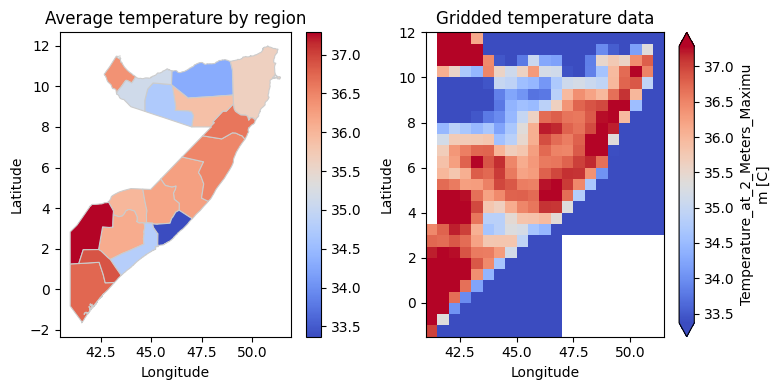

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming you have GeoDataFrames 'merged' and 'one_month_region' already defined

# Determine the color scale limits based on your data
vmin = merged['T2M_MAX'].min()
vmax = merged['T2M_MAX'].max()

# Plot the first map - Regions of Somalia colored by tmx
cax1 = merged.plot(column='T2M_MAX', cmap='coolwarm', linewidth=0.8, ax=ax1, edgecolor='0.8', legend=True, vmin=vmin, vmax=vmax)
ax1.set_title('Average temperature by region')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Plot the second map - two_months_region
cax2 = one_month_region.plot(ax=ax2, cmap='coolwarm', vmin=vmin, vmax=vmax)
ax2.set_title('Gridded temperature data')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
# Create a common colorbar for both subplots
#divider = make_axes_locatable(ax2)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#plt.colorbar(cax=cax, mappable=cax2)

plt.tight_layout()
plt.show()

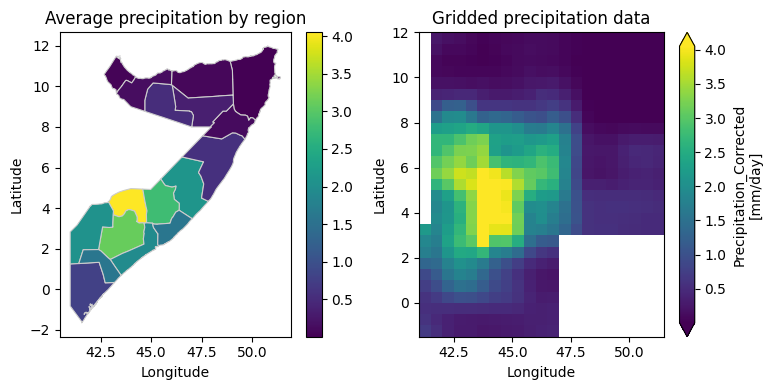

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming you have GeoDataFrames 'merged' and 'one_month_region' already defined

# Determine the color scale limits based on your data
vmin = merged['PRECTOTCORR'].min()
vmax = merged['PRECTOTCORR'].max()

# Plot the first map - Regions of Somalia colored by tmx
cax1 = merged.plot(column='PRECTOTCORR', cmap='viridis', linewidth=0.8, ax=ax1, edgecolor='0.8', legend=True, vmin=vmin, vmax=vmax)
ax1.set_title('Average precipitation by region')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Plot the second map - two_months_region
cax2 = one_month_region_p.plot(ax=ax2, cmap='viridis', vmin=vmin, vmax=vmax)
ax2.set_title('Gridded precipitation data')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
# Create a common colorbar for both subplots
#divider = make_axes_locatable(ax2)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#plt.colorbar(cax=cax, mappable=cax2)

plt.tight_layout()
plt.show()

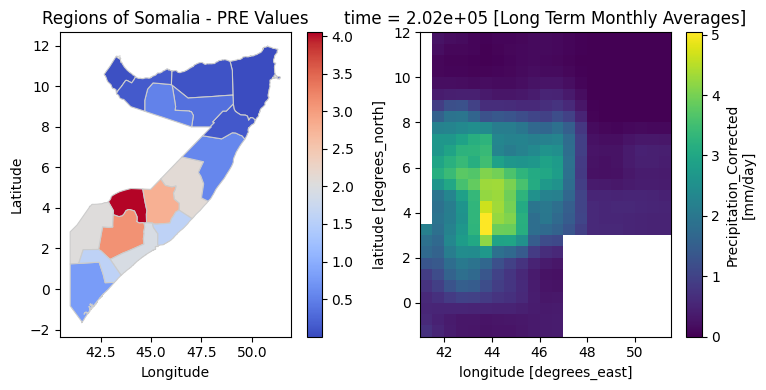

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first map - Regions of Somalia colored by tmx
merged.plot(column='PRECTOTCORR', cmap='coolwarm', linewidth=0.8, ax=ax1, edgecolor='0.8', legend=True)
ax1.set_title('Regions of Somalia - PRE Values')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Plot the second map - two_months_region
one_month_region_p.plot(ax=ax2)

plt.tight_layout()
plt.show()

In [76]:
region_summary

,time,region,PRECTOTCORR,T2M_MAX
10,199701.0,Middle Shabelle,0.000,33.620003
27,199702.0,Middle Shabelle,0.000,34.886002
44,199703.0,Middle Shabelle,0.708,35.232002
61,199704.0,Middle Shabelle,5.280,35.709999
78,199705.0,Middle Shabelle,1.622,33.397999
...,...,...,...,...
5229,202009.0,Middle Shabelle,7.664,31.281998
5246,202010.0,Middle Shabelle,1.586,33.368004
5263,202011.0,Middle Shabelle,1.406,33.543999
5280,202012.0,Middle Shabelle,0.012,33.919998


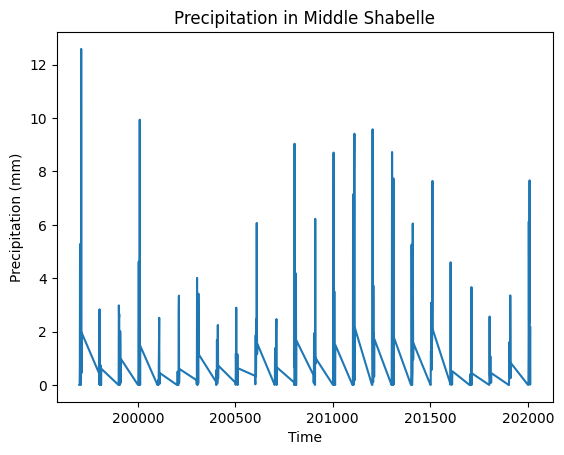

In [83]:
#subset by region and time
region = 'Middle Shabelle'
#get year and month

region_summary = summary[(summary['region'] == region)]# & (summary['time'] > 201901) & (summary['time'] < 202001)]
region_summary = region_summary.set_index('time')
#to datetime
#plot line with dots
fig, ax = plt.subplots()
region_summary['PRECTOTCORR'].plot(ax=ax)
ax.set_title('Precipitation in Middle Shabelle')
ax.set_ylabel('Precipitation (mm)')
ax.set_xlabel('Time')
plt.show()


<Axes: >

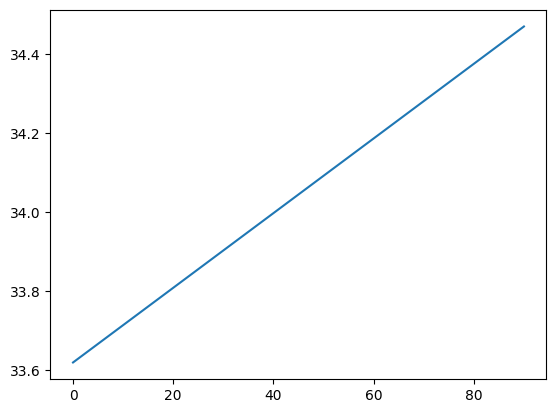

In [95]:
#plot t2m max against index
fig, ax = plt.subplots()
#region_summary.reset_index(inplace=True)
#take only a quarter of dataset
region_summary = region_summary[::3] 
region_summary['T2M_MAX'].plot(ax=ax)
